# DistilBERT 를 이용하여, 뉴스 기사에 대한 감정 분석 모델 만들기

In [1]:
import time

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from transformers import DistilBertTokenizer
from datasets import load_dataset

## AG News 데이터셋 로드
- 100 만건 이상의 뉴스 기사 데이터셋
- 4개의 뉴스 카테고리
    - 1: World, 2: Sports, 3: Business, 4: Science/Technology
- 뉴스 기사 제목과 내용으로 구성

In [2]:
ds = load_dataset("fancyzhx/ag_news")

print(ds["train"][0])

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [3]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer

/Users/joyuiyeong/.pyenv/versions/3.11.9/envs/deeplearning/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
def collate_ag_news(batch):
    """
    AG News 데이터셋을 위한 collate 함수
    DistilBertTokenizer 를 이용하여, input_ids, attention_mask, labels 를 반환
    """
    texts, labels = [], []

    for row in batch:
        texts.append(row["text"])
        labels.append(row["label"])

    tokenized = tokenizer(texts, padding=True, return_tensors="pt")

    return tokenized.input_ids, tokenized.attention_mask, torch.LongTensor(labels)


train_data_loader = DataLoader(
    ds["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_ag_news
)
test_data_loader = DataLoader(
    ds["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ag_news
)

In [6]:
distilled_bert = torch.hub.load(
    "huggingface/pytorch-transformers", "model", "distilbert-base-uncased"
)
distilled_bert

Using cache found in /Users/joyuiyeong/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [7]:
class NewsClassifier(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.encoder = pretrained_model

        # DistilBERT-base의 hidden size는 768.
        # AG news dataset 의 카테고리는 4개.
        self.classifier = nn.Linear(768, 4)

    def forward(self, inputs, attention_masks):
        # x.shape: (batch_size, seq_len)
        x = self.encoder(
            inputs, attention_mask=attention_masks
        ).last_hidden_state  # x.shape: (batch_size, seq_len, hidden_size)
        x = x[:, 0]  # x.shape: (batch_size, hidden_size)
        x = self.classifier(x)  # x.shape: (batch_size, 4)
        return x

In [8]:
my_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

classifier_model = NewsClassifier(distilled_bert).to(my_device)
classifier_model

NewsClassifier(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

- DistillBERT 의 parameter 를 freezing

In [9]:
for param in classifier_model.encoder.parameters():
    param.requires_grad = False

## Accuracy 계산 함수

In [10]:
def cal_accuracy(device, model, data_loader):
    total = 0
    correctness = 0

    for data in data_loader:
        inputs, masks, labels = data
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        outputs = model(inputs, masks)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correctness += (predicted == labels).sum().item()

    return correctness / total

## 모델 학습

In [11]:
optimizer = Adam(classifier_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [12]:
train_accuracies = []
test_accuracies = []

for epoch in range(1):
    classifier_model.train()

    total_loss = 0.0
    start_time = time.time()
    for data in train_data_loader:
        optimizer.zero_grad()

        inputs, attention_masks, labels = data
        inputs, attention_masks, labels = (
            inputs.to(my_device),
            attention_masks.to(my_device),
            labels.to(my_device),
        )

        outputs = classifier_model(inputs, attention_masks)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(
        f"Epoch {epoch+1:3d} | {time.time() - start_time:.2f}s | Total Loss: {total_loss:.4f}"
    )

    with torch.no_grad():
        classifier_model.eval()

        train_accuracy = cal_accuracy(my_device, classifier_model, train_data_loader)
        test_accuracy = cal_accuracy(my_device, classifier_model, test_data_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(
            f"    ===> Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}"
        )

Epoch   1 | 380.13s | Total Loss: 664.5565
    ===> Train Accuracy: 0.8979, Test Accuracy: 0.8970


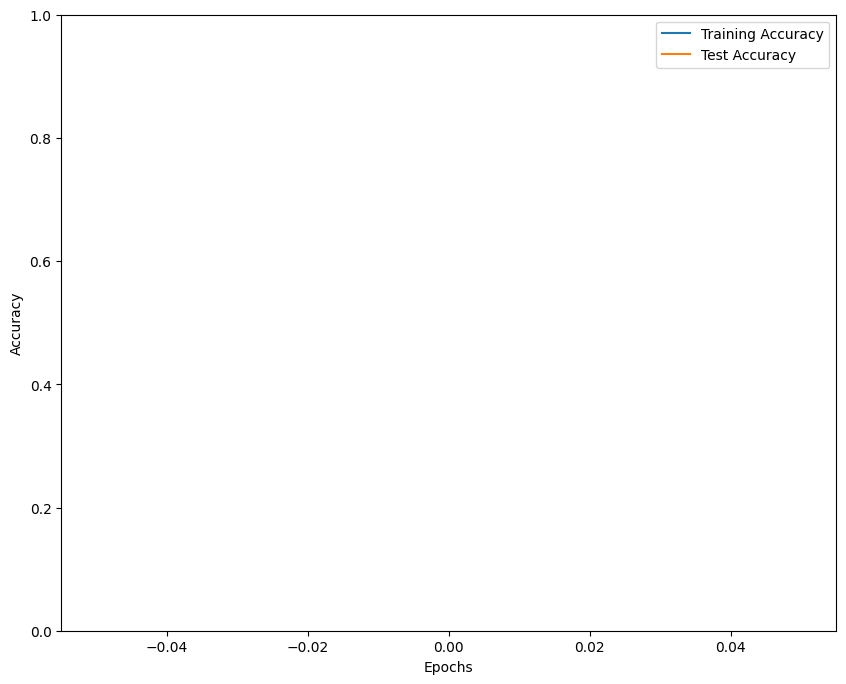

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

x_axis = np.arange(len(train_accuracies))
plt.plot(x_axis, train_accuracies, label="Training Accuracy")
plt.plot(x_axis, test_accuracies, label="Test Accuracy")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()